In [1]:
import sys
import os
sys.path.append("src/")
from src import *
sys.path.append("scripts/")
from ixnos import iXnos
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from Bio import SeqIO
import seaborn as sns
import random
import itertools

iwasaki_n3p2 = iXnos(min_codon=-3, max_codon=2)
iwasaki_n3p2.load_state_dict(torch.load("processed-data/iwasaki/models/ixnos_n3p2_full.pth", weights_only=False))
iwasaki_n3p2.eval()

ansari_n3p2 = iXnos(min_codon=-3, max_codon=2)
ansari_n3p2.load_state_dict(torch.load("processed-data/thp1_v2/models/ixnos_n3p2_full.pth"))
ansari_n3p2.eval() 

model = iwasaki_n3p2

/tmp/ipykernel_7339/2273994592.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ansari_n3p2.load_state_dict(torch.load("processed-data/thp1_v2/models/ixnos_n3p2_full.pth

In [2]:
cit_seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'
seq = cit_seq[:20]

In [3]:
fastest, fv = model.optimize_codons(seq, sanity_check=True)
slowest, sv = model.optimize_codons(seq, fastest=False, sanity_check=True)

In [4]:
seqs, speeds = model.predict_random_speeds(seq, 1000)

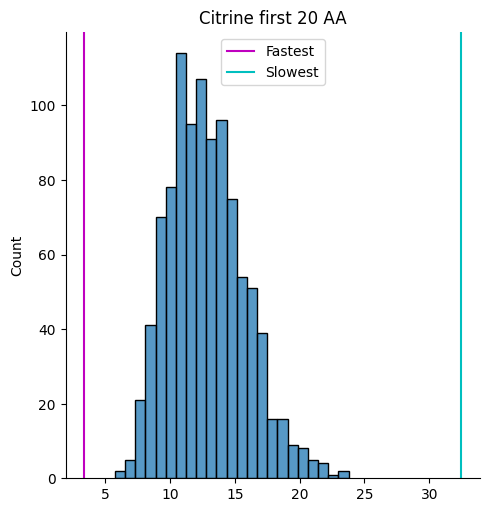

In [5]:
fastscore = model.predict_elongation(fastest)
slowscore = model.predict_elongation(slowest)

sns.displot(speeds)
plt.axvline(fastscore, c='m', label="Fastest")
plt.axvline(slowscore, c='c', label='Slowest')
plt.legend()
plt.title("Citrine first 20 AA")
plt.show()

In [6]:
(fv == fastscore), (sv == slowscore)

(True, False)

In [7]:
cit_seq

'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

In [8]:
fastest, fv = iwasaki_n3p2.optimize_codons(cit_seq, sanity_check=True)


In [9]:
slowest, sv = iwasaki_n3p2.optimize_codons(cit_seq, fastest=False, sanity_check=True)

In [10]:
# seqs, speeds = model.predict_random_speeds(cit_seq, 3_000)
seqs, speeds = pd.read_csv("processed-data/iwasaki_vs_ansari_ecitrine_n3p2.csv")[["seq", "speeds_iwasaki"]].T.values

113.27043265104294 113.44956296682358
422.0954737663269 427.8999627828598


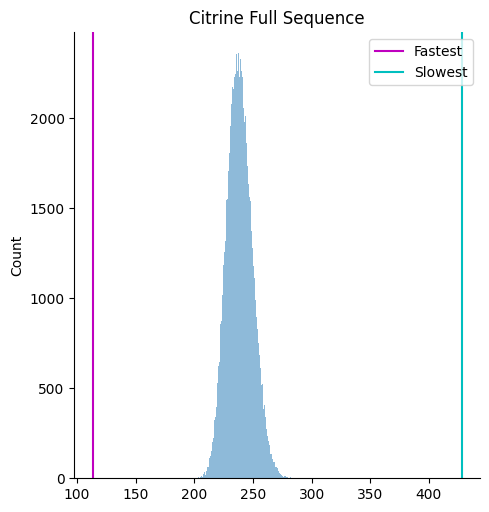

In [11]:
fastscore = model.predict_elongation(fastest)
slowscore = model.predict_elongation(slowest)
print(fv, fastscore)
print(sv, slowscore)
# slowscore = model.predict_elongation(slowest)

sns.displot(speeds, edgecolor=None, alpha=0.5)#, kind="kde")
plt.axvline(fastscore, c='m', label="Fastest")
plt.axvline(slowscore, c='c', label='Slowest')
plt.legend()
plt.title("Citrine Full Sequence")
plt.show()

## Compare this to the original model's optimal

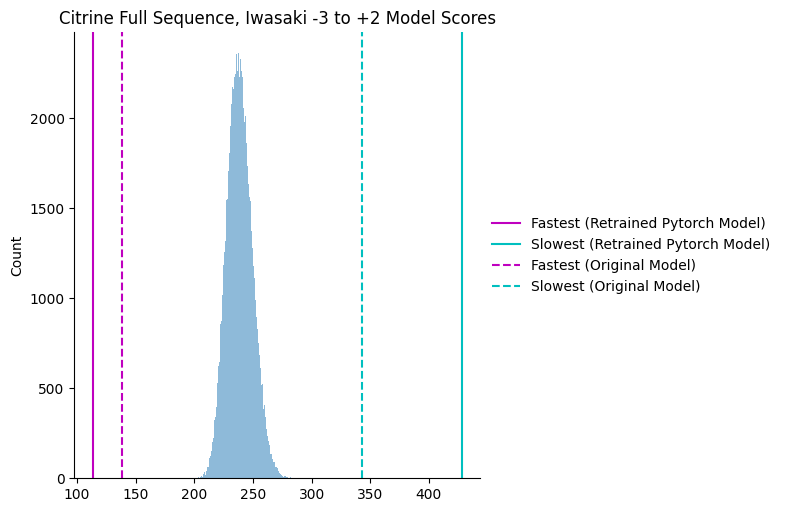

In [12]:
cit_df = pd.read_csv("processed-data/citrine_fluorescence_expanded.csv")
cit_df = cit_df[cit_df["mod"] != "M"]
fastest_orig = cit_df.loc[cit_df["cit"] == "citmin", "seq"].unique().item()
slowest_orig = cit_df.loc[cit_df["cit"] == "citmax", "seq"].unique().item()

fastscore_orig = model.predict_elongation(fastest_orig)
slowscore_orig = model.predict_elongation(slowest_orig)

sns.displot(speeds, edgecolor=None, alpha=0.5)#, kind="kde")
plt.axvline(fastscore, c='m', label="Fastest (Retrained Pytorch Model)")
plt.axvline(slowscore, c='c', label='Slowest (Retrained Pytorch Model)')
plt.axvline(fastscore_orig, c='m', linestyle="--", label="Fastest (Original Model)")
plt.axvline(slowscore_orig, c='c', linestyle="--", label='Slowest (Original Model)')
plt.legend()
plt.title("Citrine Full Sequence, Iwasaki -3 to +2 Model Scores")
plt.legend(**legend_kwargs())
plt.show()

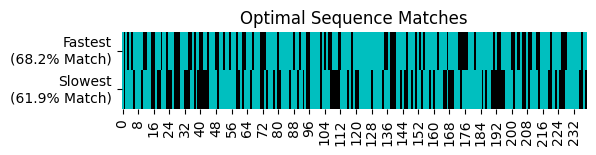

In [13]:
get_codons = lambda x: [x[i:i+3] for i in range(0, len(x), 3)]
codons_fastest = get_codons(fastest)
codons_fastest_orig = get_codons(fastest_orig)
codons_slowest = get_codons(slowest)
codons_slowest_orig = get_codons(slowest_orig)

matches_fastest = [codons_fastest[i] == codons_fastest_orig[i] for i in range(len(codons_fastest))]
matches_slowest = [codons_slowest[i] == codons_slowest_orig[i] for i in range(len(codons_slowest))]
matches = pd.DataFrame({
    f"Fastest\n({sum(matches_fastest) / len(matches_fastest) :.1%} Match)": matches_fastest,
    f"Slowest\n({sum(matches_slowest) / len(matches_slowest) :.1%} Match)": matches_slowest
})
fig, ax = plt.subplots(figsize=(6, 1))
sns.heatmap(matches.T, cmap=["k", "c"], cbar=False, ax=ax,)
ax.set_title("Optimal Sequence Matches")
plt.show()

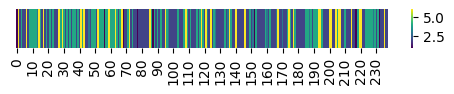

In [14]:
cit_degeneracy = pd.DataFrame([len(iXnos.get_aa_to_codon()[i]) for i in list(cit_seq)]).T
fig, ax = plt.subplots(figsize=(6, .5))
sns.heatmap(cit_degeneracy, cmap="viridis")
ax.set_yticks([])
plt.show()

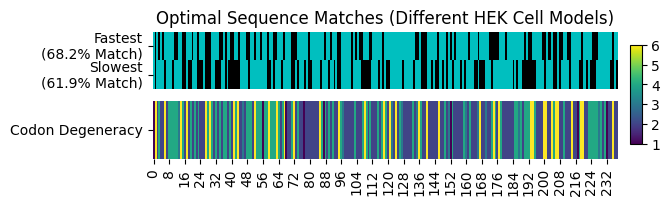

In [31]:
from matplotlib import colors as mcolors

fig, axs = plt.subplots(2, 1, figsize=(6, 1.65))
sns.heatmap(matches.T, cmap=["k", "c"], cbar=False, ax=axs[0],)
h2 = sns.heatmap(cit_degeneracy, cmap="viridis", ax=axs[1], cbar=False)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  
# plt.colorbar(h2.collections[0], ax=axs[1], cax=cbar_ax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis", norm=mcolors.Normalize(vmin=1, vmax=6)), cax=cbar_ax,)
cbar.set_ticks([1, 2, 3, 4, 5, 6])  # Custom integer ticks
cbar.set_ticklabels([str(i) for i in range(1, 7)])  # Labels for each integer category

axs[1].set_yticklabels(["Codon Degeneracy"], rotation=0)
axs[0].set_xticks([])
axs[0].set_title("Optimal Sequence Matches (Different HEK Cell Models)")
plt.show()

In [117]:
from Bio.Seq import Seq
# print(str(Seq(fastest).translate())[:-1] == cit_seq)
cod2aa = {
        'AAA':'K', 'AAG':'K', 'AAC':'N', 'AAT':'N', 'ACA':'T', 'ACC':'T', 
        'ACG':'T', 'ACT':'T', 'AGA':'R', 'AGG':'R', 'CGA':'R', 'CGC':'R', 
        'CGG':'R', 'CGT':'R', 'AGC':'S', 'AGT':'S', 'TCA':'S', 'TCC':'S', 
        'TCG':'S', 'TCT':'S', 'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'CAA':'Q', 'CAG':'Q', 'CAC':'H', 'CAT':'H', 'CCA':'P', 'CCC':'P', 
        'CCG':'P', 'CCT':'P', 'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'TTA':'L', 'TTG':'L', 'TTC':'F', 'TTT':'F', 'GAA':'E', 'GAG':'E',
        'GAC':'D', 'GAT':'D', 'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 'GTA':'V', 'GTC':'V',
        'GTG':'V', 'GTT':'V', 'TAA':'*', 'TAG':'*', 'TGA':'*',
        'TAC':'Y', 'TAT':'Y', 'TGG':'W', 'TGC':'C', 'TGT':'C'}

print(pd.Series(list(cit_seq)).value_counts(normalize=True))

pd.Series([cod2aa[codons_fastest[i]] for i in range(len(cit_seq)) if (codons_fastest[i] == codons_fastest_orig[i])]).value_counts(normalize=True)

G    0.096639
L    0.088235
K    0.084034
D    0.075630
E    0.067227
V    0.067227
T    0.058824
N    0.054622
I    0.050420
Y    0.050420
F    0.050420
P    0.042017
H    0.042017
S    0.037815
A    0.037815
M    0.029412
Q    0.029412
R    0.025210
C    0.008403
W    0.004202
Name: proportion, dtype: float64


G    0.111111
E    0.086420
D    0.086420
K    0.080247
N    0.074074
F    0.074074
V    0.061728
I    0.055556
H    0.049383
Y    0.049383
T    0.049383
M    0.043210
L    0.043210
A    0.037037
P    0.030864
Q    0.030864
C    0.012346
R    0.012346
W    0.006173
S    0.006173
Name: proportion, dtype: float64

## Compare to Ansari model optimal

In [16]:
fastest_ans, fv_ans = ansari_n3p2.optimize_codons(cit_seq, sanity_check=True)
fastscore_ans = ansari_n3p2.predict_elongation(fastest_ans)

In [22]:
slowest_ans, sv_ans = ansari_n3p2.optimize_codons(cit_seq, sanity_check=True, fastest=False)
slowscore_ans = ansari_n3p2.predict_elongation(slowest_ans)

In [32]:
codons_fastest_ans = get_codons(fastest_ans)
matches_fastest_models = [codons_fastest[i] == codons_fastest_ans[i] for i in range(len(codons_fastest))]
codons_slowest_ans = get_codons(slowest_ans)
matches_slowest_models = [codons_slowest[i] == codons_slowest_ans[i] for i in range(len(codons_slowest))]

# sns.heatmap(np.array(matches_fastest_models).reshape(1, -1))
# plt.show()

# sum(matches_fastest_models) / len(matches_fastest_models)

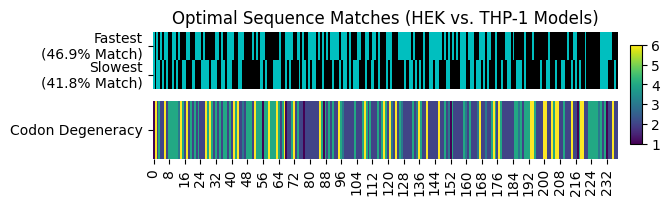

In [33]:
matches_models = pd.DataFrame({
    f"Fastest\n({sum(matches_fastest_models) / len(matches_fastest_models) :.1%} Match)": matches_fastest_models,
    f"Slowest\n({sum(matches_slowest_models) / len(matches_slowest_models) :.1%} Match)": matches_slowest_models
})

fig, axs = plt.subplots(2, 1, figsize=(6, 1.65))
sns.heatmap(matches_models.T, cmap=["k", "c"], cbar=False, ax=axs[0],)
h2 = sns.heatmap(cit_degeneracy, cmap="viridis", ax=axs[1], cbar=False)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  
# plt.colorbar(h2.collections[0], ax=axs[1], cax=cbar_ax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis", norm=mcolors.Normalize(vmin=1, vmax=6)), cax=cbar_ax,)
cbar.set_ticks([1, 2, 3, 4, 5, 6])  # Custom integer ticks
cbar.set_ticklabels([str(i) for i in range(1, 7)])  # Labels for each integer category

axs[1].set_yticklabels(["Codon Degeneracy"], rotation=0)
axs[0].set_xticks([])
axs[0].set_title("Optimal Sequence Matches (HEK vs. THP-1 Models)")
plt.show()

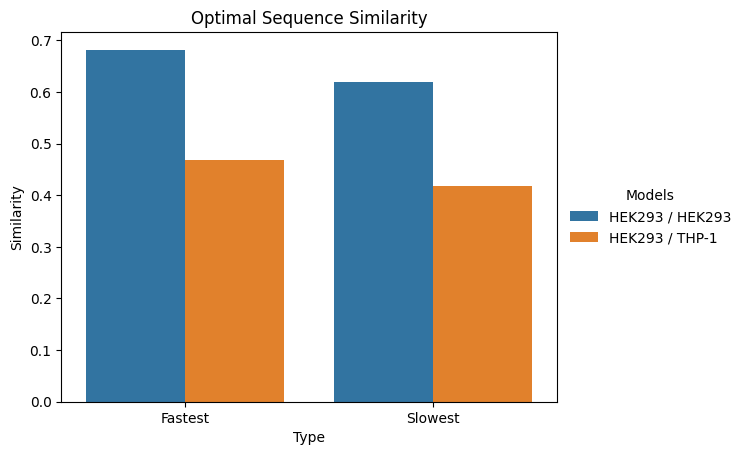

In [62]:
# pd.concat([matches, matches_models], axis=1)
mdf = pd.DataFrame([
    ["HEK293 / HEK293", sum(matches_fastest) / len(matches_fastest), "Fastest"],
    ["HEK293 / HEK293", sum(matches_slowest) / len(matches_slowest), "Slowest"],
    ["HEK293 / THP-1", sum(matches_fastest_models) / len(matches_fastest_models), "Fastest"],
    ["HEK293 / THP-1", sum(matches_slowest_models) / len(matches_slowest_models), "Slowest"],
], columns=["Models", "Similarity", "Type"])
sns.barplot(mdf, x="Type", y="Similarity", hue="Models",)
plt.title("Optimal Sequence Similarity")
plt.legend(title="Models", **legend_kwargs())
plt.show()

In [57]:
mdf

,Models,Similarity,Type
0,HEK293 / HEK293,0.468619,Fastest
1,HEK293 / HEK293,0.418410,Slowest
2,HEK293 / THP-1,0.682008,Fastest
3,HEK293 / THP-1,0.619247,Slowest


## Scoring the original model --  NEED TO FIND n3p2 MODELS!

In [26]:
import pickle
from collections import OrderedDict

def load_ixnos(pklpath, **kwargs):
    # 
    # device = (
    #     "cuda"
    #     if torch.cuda.is_available()
    #     else "mps"
    #     if torch.backends.mps.is_available()
    #     else "cpu"
    # )
    # print(f"Using {device} device")
    model = iXnos(**kwargs)#.to(device)

    with open(pklpath, 'rb') as file:
        # Load the pickled data
        data = pickle.load(file, encoding='bytes')
    for idx, val in enumerate(data):
        data[idx] = torch.from_numpy(val).T
    layer_name = "layers"
    labels = [
        f"{layer_name}.0.weight", f"{layer_name}.0.bias", 
        f"{layer_name}.2.weight", f"{layer_name}.2.bias"]

    old_model = OrderedDict(zip(labels, data))

    model.load_state_dict(old_model)
    return model
# pklpath = "iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/codon_scores.pkl"
pklpath = "iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/weights.pkl"
model_orig = load_ixnos(pklpath, min_codon=-5, max_codon=4)
model_orig.eval()

iXnos(
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [27]:
model_orig.predict_elongation(fastest)

115.92713648080826

In [ ]:
fastest_orig, fv_orig = model_orig.optimize_codons(cit_seq, fastest=True, sanity_check=True)

In [38]:
model_orig.optimize_codons(cit_seq[:10], fastest=True,)

'ATGTCTAAAGGGGAGGAATTATTTACAGGT'

In [39]:
model.optimize_codons(cit_seq[:10], fastest=True,)

'ATGTCCAAGGGTGAGGAATTGTTTACTGGT'

# SCRATCH WORK FOR DEVELOPING OPTIMIZATION FN

In [ ]:

let2cod = iXnos.get_aa_to_codon()

def zeta(aa_seq, c_rel_min, c_rel_max):
    possible_codons = [let2cod[i] for i in aa_seq]
    if len(aa_seq) < c_rel_max + 1 - c_rel_min:
        possible_codons = [["NNN"] for _ in range(c_rel_max + 1 - c_rel_min - len(aa_seq))] + possible_codons
    return list(itertools.product(*possible_codons))

c_rel_min, c_rel_max = -3, 2
L = len(seq)
Q, T = [], []
c_min = np.zeros(L, dtype=int)
c_max = np.zeros(L, dtype=int)


print(seq)
for i in range(L):
    c_min[i] = max(0, i + c_rel_min - c_rel_max)
    c_max[i] = i + 1
    Q.append(zeta(seq[c_min[i]: c_max[i]], c_rel_min, c_rel_max))
    # Calculate expected ribo counts
    T.append([])
    for q in Q[i]:
        prediction_q = model.predict(model.get_inputs(q)).item()
        T[i].append(prediction_q)

MSKGEELFTGVVPILVELDG


In [133]:
P, V = [], []
for i in range(L):
    P.append([])
    V.append([])
    if i == 0:
        for q_i, q in enumerate(Q[i]):
            P[i].append(np.nan)
            V[i].append(T[i][q_i])
    else:
        for q_i, q in enumerate(Q[i]):
            # Get indices of previous aa that match the possible codon sequences preceding this aa
            previous_indices = np.where([q_prev[1:] == q[:-1] for q_prev in Q[i - 1]])[0]
            P_i_q = int(previous_indices[np.argmin([V[i - 1][j] for j in previous_indices])])
            P[i].append(P_i_q)
            V[i].append(V[i-1][P_i_q] + T[i][q_i])

In [134]:
q_L = np.argmin(V[-1])
p_i = P[-1][q_L]
cds = "".join(Q[-1][q_L])
i = 0
# print(p_i)
for _ in range(L - 1 - (c_rel_max - c_rel_min)):
    i -= 1
    p_i = P[i][p_i]
    q_i = Q[i - 1][p_i]
    cds = q_i[0] + cds
    # print(p_i)
cds

'ATGTCCAAGGGTGAGGAATTGTTTACTGGTGTTGTTCCCATTCTTGTGGAATTGGATGGT'

In [135]:
len(cds) / 3
model.predict_elongation(cds)

3.3196821212768555

In [141]:
model.predict(model.get_inputs(Q[-1][q_L])) #+ min(V[-1])
min(V[-1])

3.3196821212768555

In [138]:
seqs, speeds = model.predict_random_speeds(seq, 1000)

3.3196821212768555


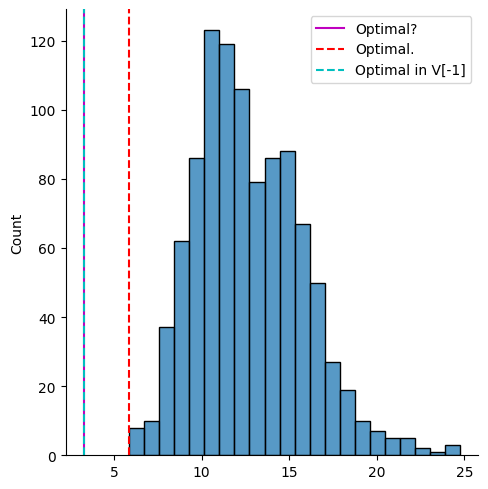

In [143]:
opt = model.predict_elongation(cds)
print(opt)

sns.displot(speeds)
plt.axvline(opt, c='m', label="Optimal?")
plt.axvline(min(speeds), c='r', linestyle="--", label="Optimal.")
plt.axvline(min(V[-1]), c='c', linestyle="--", label="Optimal in V[-1]")
plt.legend()
plt.show()


In [ ]:
def optimize_codons(seq, fastest=True):

    let2cod = iXnos.get_aa_to_codon()

    def zeta(aa_seq, c_rel_min, c_rel_max):
        # Generate a list of all possible codon combinations for a given AA sequence
        possible_codons = [let2cod[i] for i in aa_seq]
        if len(aa_seq) < c_rel_max + 1 - c_rel_min:
            possible_codons = [["NNN"] for _ in range(c_rel_max + 1 - c_rel_min - len(aa_seq))] + possible_codons
        return list(itertools.product(*possible_codons))

    c_rel_min, c_rel_max = -3, 2
    L = len(seq)
    # Q[i] contains possible codon combinations within the iXnos window at position i
    # T[i] contains the iXnos predictions for each combination in Q[i]
    Q, T = [], [] 
    c_min = np.zeros(L, dtype=int)
    c_max = np.zeros(L, dtype=int)
    # Iterate through the given AA sequence, get combos of possible codon combinations at 
    # each pertinent iXnos window, and calculate + store iXnos prediction for each codon set
    for i in range(L):
        c_min[i] = max(0, i + c_rel_min - c_rel_max)
        c_max[i] = i + 1
        Q.append(zeta(seq[c_min[i]: c_max[i]], c_rel_min, c_rel_max))
        # Calculate expected ribo counts
        T.append([])
        for q in Q[i]:
            prediction_q = model.predict(model.get_inputs(q)).item()
            T[i].append(prediction_q)
    # Calculate optimal preceding sequence sets for each sequence set
    # P[i] stores the index of the shortest path so far running through each possible sequence combo in Q
    # V[i] stores the running sum of iXnos-predicted counts at each position i
    P, V = [], []
    for i in range(L):
        P.append([])
        V.append([])
        if i == 0:
            for q_i, q in enumerate(Q[i]):
                P[i].append(np.nan)
                V[i].append(T[i][q_i])
        else:
            for q_i, q in enumerate(Q[i]):
                # Get indices of previous aa that match the possible codon sequences preceding this aa
                previous_indices = np.where([q_prev[1:] == q[:-1] for q_prev in Q[i - 1]])[0]
                # Find either the fastest or slowest possible path that ends in this particular codon combo
                if fastest:
                    P_i_q = int(previous_indices[np.argmin([V[i - 1][j] for j in previous_indices])])
                else:
                    P_i_q = int(previous_indices[np.argmax([V[i - 1][j] for j in previous_indices])])
                P[i].append(P_i_q)
                V[i].append(V[i-1][P_i_q] + T[i][q_i])
    # Backtrack through these arrays, starting at the lowest possible final V and using the 
    # corresponding P for that, and construct the optimal CDS from that
    # NOTE: I've noticed that for small sequences, the min V[-1] is not the same as the 
    # final predicted summed overall counts for the cds output... 
    q_L = np.argmin(V[-1]) if fastest else np.argmax(V[-1])
    p_i = P[-1][q_L]
    cds = "".join(Q[-1][q_L])
    i = 0
    for _ in range(L - 1 - (c_rel_max - c_rel_min)):
        i -= 1
        p_i = P[i][p_i]
        q_i = Q[i - 1][p_i]
        cds = q_i[0] + cds
    return cds

'ATGTCCAAGGGTGAGGAATTGTTTACTGGTGTTGTTCCCATTCTTGTGGAATTGGATGGT'

In [ ]:
fastest = True
seq = cit_seq
let2cod = iXnos.get_aa_to_codon()

def zeta(aa_seq, c_rel_min, c_rel_max):
    # Generate a list of all possible codon combinations for a given AA sequence
    possible_codons = [let2cod[i] for i in aa_seq]
    if len(aa_seq) < c_rel_max + 1 - c_rel_min:
        possible_codons = [["NNN"] for _ in range(c_rel_max + 1 - c_rel_min - len(aa_seq))] + possible_codons
    return list(itertools.product(*possible_codons))

c_rel_min, c_rel_max = -3, 2
L = len(seq)
# Q[i] contains possible codon combinations within the iXnos window at position i
# T[i] contains the iXnos predictions for each combination in Q[i]
Q, T = [], [] 
c_min = np.zeros(L, dtype=int)
c_max = np.zeros(L, dtype=int)
# Iterate through the given AA sequence, get combos of possible codon combinations at 
# each pertinent iXnos window, and calculate + store iXnos prediction for each codon set
for i in range(L):
    c_min[i] = max(0, i + c_rel_min - c_rel_max)
    c_max[i] = i + 1
    Q.append(zeta(seq[c_min[i]: c_max[i]], c_rel_min, c_rel_max))
    # Calculate expected ribo counts
    T.append([])
    for q in Q[i]:
        prediction_q = model.predict(model.get_inputs(q)).item()
        T[i].append(prediction_q)
# Calculate optimal preceding sequence sets for each sequence set
# P[i] stores the index of the shortest path so far running through each possible sequence combo in Q
# V[i] stores the running sum of iXnos-predicted counts at each position i
P, V = [], []
for i in range(L):
    P.append([])
    V.append([])
    if i == 0:
        for q_i, q in enumerate(Q[i]):
            P[i].append(np.nan)
            V[i].append(T[i][q_i])
    else:
        for q_i, q in enumerate(Q[i]):
            # Get indices of previous aa that match the possible codon sequences preceding this aa
            previous_indices = np.where([q_prev[1:] == q[:-1] for q_prev in Q[i - 1]])[0]
            # Find either the fastest or slowest possible path that ends in this particular codon combo
            if fastest:
                P_i_q = int(previous_indices[np.argmin([V[i - 1][j] for j in previous_indices])])
            else:
                P_i_q = int(previous_indices[np.argmax([V[i - 1][j] for j in previous_indices])])
            P[i].append(P_i_q)
            V[i].append(V[i-1][P_i_q] + T[i][q_i])
# Backtrack through these arrays, starting at the lowest possible final V and using the 
# corresponding P for that, and construct the optimal CDS from that
# NOTE: I've noticed that for small sequences, the min V[-1] is not the same as the 
# final predicted summed overall counts for the cds output... 
q_L = np.argmin(V[-1]) if fastest else np.argmax(V[-1])
p_i = P[-1][q_L]
cds = "".join(Q[-1][q_L])
i = 0
for _ in range(L - 1 - (c_rel_max - c_rel_min)):
    i -= 1
    p_i = P[i][p_i]
    q_i = Q[i - 1][p_i]
    cds = q_i[0] + cds


IndexError: list index out of range

In [57]:
Q[-1][q_L]
p0 = P[-1][q_L]
P[-3][P[-2][p0]]

109

In [63]:
min(V[-1])

113.10041779279709

In [81]:
list(range(-10,-1))

[-10, -9, -8, -7, -6, -5, -4, -3, -2]

In [ ]:
q_L = np.argmin(V[-1]) if fastest else np.argmax(V[-1])
p_i = P[-1][q_L]
cds = "".join(Q[-1][q_L])
# i = -1
# print(Q[-1][q_L])
for i in range(-(L - (c_rel_max - c_rel_min)), -1)[::-1]:
    q_i = Q[i][p_i]
    p_i = P[i][p_i]
    cds = q_i[0] + cds
    # print(q_i, i, cds)
print(len(cds) / 3)
cds

('ATG', 'GAT', 'GAG', 'TTG', 'TAC', 'AAA')
238.0


'ATGTCCAAGGGTGAGGAATTGTTTACTGGTGTTGTTCCCATTCTTGTGGAGTTGGATGGTGACGTGAATGGGCATAAGTTTAGCGTGAGCGGTGAGGGTGAGGGTGATGCGACTTATGGTAAATTAACTCTTAAATTTATTTGTACTACTGGTAAACTGCCCGTGCCCTGGCCCACGTTGGTGACGACTCTTGGTTATGGTCTTATGTGTTTTGCCAGGTATCCCGACCATATGAAGCAGCACGATTTTTTTAAGAGTGCGATGCCCGAGGGTTATGTGCAGGAGAGGACTATTTTTTTTAAGGATGACGGTAACTATAAGACGCGGGCGGAGGTTAAATTTGAGGGTGATACGCTTGTGAATAGGATTGAGTTGAAGGGGATTGATTTTAAGGAGGATGGTAATATTCTTGGTCACAAACTTGAGTATAATTATAATAGTCATAATGTATATATAATGGCCGATAAGCAAAAGAATGGTATTAAGGTTAATTTTAAGATTAGACATAATATTGAGGATGGGTCCGTACAACTTGCGGATCATTACCAACAAAATACCCCAATTGGTGATGGTCCCGTATTACTTCCCGATAATCATTATCTTAGTTATCAAAGTGCGTTGAGTAAGGATCCGAATGAGAAACGGGACCATATGGTGCTGTTGGAGTTTGTGACGGCGGCCGGTATTACGCATGGGATGGATGAGTTGTACAAA'

In [113]:
print(min(V[-1]))
print(model.predict_elongation(cds))
len(cds) / 3

113.10041779279709
113.10041779279709


238.0

In [109]:
cds

'ATGTCCAAGGGTGAGGAATTGTTTACTGGTGTTGTTCCCATTCTTGTGGAGTTGGATGGTGACGTGAATGGGCATAAGTTTAGCGTGAGCGGTGAGGGTGAGGGTGATGCGACTTATGGTAAATTAACTCTTAAATTTATTTGTACTACTGGTAAACTGCCCGTGCCCTGGCCCACGTTGGTGACGACTCTTGGTTATGGTCTTATGTGTTTTGCCAGGTATCCCGACCATATGAAGCAGCACGATTTTTTTAAGAGTGCGATGCCCGAGGGTTATGTGCAGGAGAGGACTATTTTTTTTAAGGATGACGGTAACTATAAGACGCGGGCGGAGGTTAAATTTGAGGGTGATACGCTTGTGAATAGGATTGAGTTGAAGGGGATTGATTTTAAGGAGGATGGTAATATTCTTGGTCACAAACTTGAGTATAATTATAATAGTCATAATGTATATATAATGGCCGATAAGCAAAAGAATGGTATTAAGGTTAATTTTAAGATTAGACATAATATTGAGGATGGGTCCGTACAACTTGCGGATCATTACCAACAAAATACCCCAATTGGTGATGGTCCCGTATTACTTCCCGATAATCATTATCTTAGTTATCAAAGTGCGTTGAGTAAGGATCCGAATGAGAAACGGGACCATATGGTGCTGTTGGAGTTTGTGACGGCGGCCGGTATTACGCATGGGATGGATGAGTTGTACAAA'

In [110]:
print([k for k, v in let2cod.items() if "AAA" in v])
print(cit_seq[:7])
cds[-3:]

['K']
MSKGEEL


'AAA'